In [32]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The code is hidden for the presentation mode.
To switch to the code, click <a href="javascript:code_toggle()">here</a>.''')

# Credit card fraud detection
#### This project provides predictive model for credit card fraud detection. Specifically, it is a binary classification with imbalanced dataset (%94 majority class and %6 minority class).
#### After providing some data exploratoy analysis, the following models are invesetigated and compared:
- logistic regression
- Support vector machine
- Random forest
- XGBoost

#### Additionally, I tune each model with GridSearch and Randomized Parameter Optimization to obtain the best result.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import itertools
import seaborn as sns
import Eval_Metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score

%matplotlib inline
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

## Data Exploratory

#### Fraud detection dataset is comprised of 8000 records and 100 inout features and a label feature  
#### Lets see the first 5 records:

In [34]:
data = pd.read_csv('C:/Users/sbadretale/Desktop/sample.csv')

label = data.y
label_list = ['y']

print('Number of records: ' ,data.shape[0])
print("----------  ".format(""))
print('Number of features plus label feature: ' ,data.shape[1])
data.head(5)

Number of records:  8000
----------  
Number of features plus label feature:  101


x0         x1        x2         x3        x4     x5         x6  \
0 -0.247824   6.425853 -6.485658  -8.241462       NaN  0.03%    Tuesday   
1  2.623274  -2.808263  5.321746  -2.437653  0.614041  0.02%  Wednesday   
2 -5.460551   5.997701 -4.614194  -6.035128 -1.986438  -0.0%    Tuesday   
3  1.566307  -0.080517  0.064754   6.063193 -2.253075   0.0%    Thurday   
4  0.750715  15.656095 -6.778600  11.251037 -0.308200   0.0%  Wednesday   

          x7        x8        x9 ...       x91        x92        x93  \
0  -9.808905  4.753455  2.537819 ...  0.592543  14.967527   6.691044   
1  10.710053  1.608882 -2.027541 ... -1.712788  -3.638637  -2.256492   
2  -3.364649 -2.493473  1.429913 ...  2.206956   7.292558  10.095556   
3  -6.111982 -1.796377 -3.169510 ... -3.841669   5.189840  10.291069   
4   2.498892 -0.323229 -2.624680 ...  8.933781  -7.295794 -11.246059   

        x94       x95        x96        x97       x98       x99  y  
0 -0.275572  2.518542   4.637431 -14.296510  1.898115 -1.225228  0  
1  2.703101  1.760729   2.660614   1.182922 -3.203078  0.711018  0  
2  1.601155  1.710645 -12.519434  -5.261707  2.032666 -6.445528  0  
3 -3.642396  0.674300  -1.104317  -3.922342 -0.613947  7.275179  0  
4 -4.876594  3.395415  -2.646844  -5.273267 -5.259536 -3.240523  0  

[5 rows x 101 columns]

### Detecting Null (missing) values:

#### Here we are calculating how many missing values each feature has.

#### Since in the worst case, only %1.25 of values in the feature x20 are missing, we will keep all the features.

#### If a feature has more than %50 missing values, we could consider removing that feature.

In [35]:
# Check to see if there are any missing values in our data set

total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total out of 8000 records', 'Percent'])

Total out of 8000 records  Percent
x20                        100   1.2500
x78                         98   1.2250
x86                         97   1.2125
x75                         97   1.2125
x93                         97   1.2125
x16                         97   1.2125
x84                         95   1.1875
x5                          94   1.1750
x60                         94   1.1750
x92                         93   1.1625
x47                         92   1.1500
x49                         92   1.1500
x15                         91   1.1375
x14                         91   1.1375
x70                         91   1.1375
x7                          91   1.1375
x6                          91   1.1375
x74                         90   1.1250
x63                         90   1.1250
x26                         90   1.1250
x10                         89   1.1125
x81                         88   1.1000
x91                         87   1.0875
x96                         87   1.0875
x9                          86   1.0750
x97                         86   1.0750
x51                         85   1.0625
x83                         85   1.0625
x82                         85   1.0625
x57                         85   1.0625
..                         ...      ...
x80                         74   0.9250
x18                         74   0.9250
x89                         73   0.9125
x62                         73   0.9125
x41                         73   0.9125
x52                         72   0.9000
x19                         72   0.9000
x68                         72   0.9000
x64                         72   0.9000
x46                         72   0.9000
x44                         71   0.8875
x66                         71   0.8875
x13                         71   0.8875
x94                         70   0.8750
x95                         70   0.8750
x79                         69   0.8625
x22                         69   0.8625
x21                         69   0.8625
x30                         69   0.8625
x32                         69   0.8625
x39                         69   0.8625
x48                         69   0.8625
x77                         68   0.8500
x73                         68   0.8500
x38                         68   0.8500
x90                         67   0.8375
x59                         66   0.8250
x3                          66   0.8250
x25                         54   0.6750
y                            0   0.0000

[101 rows x 2 columns]

#### Now we are calculating how many records has missing values.

#### As we see, all the 8000 records have missing values

In [36]:
print('How many records (rows) have missing values?', data[data.isnull().any(axis=1)].shape[0])

How many records (rows) have missing values? 8000


### We replaced all the missing (NaN) values with zero. 

In [37]:
## Replace all NaN elements with 0. (For now)

data = data.fillna(0)

## Now, we will find out if all the values are numerical values for analysis

#### As we see, there are 3 ordinal features. We will calculate their distribution to find out how we can replace their values with nuemrical values.

In [38]:
print('x6 feature is consist of: '  ,list(set(data.x6)))
print('x20 feature is consist of: ' ,list(set(data.x20)))
print('x27 feature is consist of: ' ,list(set(data.x27)))

x6 feature is consist of:  [0, 'Monday', 'Wednesday', 'Thurday', 'Friday', 'Tuesday']
x20 feature is consist of:  [0, 'Jan', 'Aug', 'May', 'Jun', 'Dec', 'Apr', 'Oct', 'Jul', 'Mar', 'Nov', 'Feb', 'Sept']
x27 feature is consist of:  [0, 'Afternoon', 'Night', 'Morning', 'Evening']


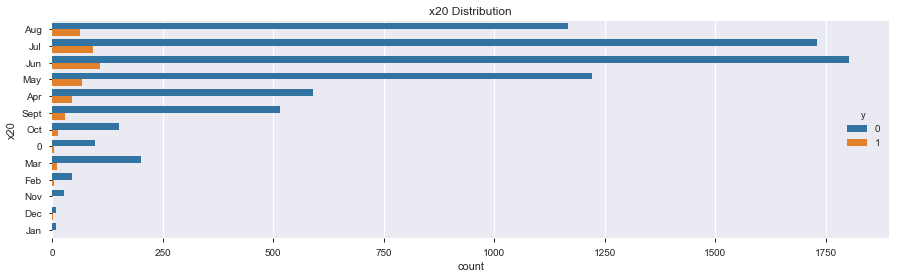

In [39]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="x20", hue='y', data=data).set_title('x20 Distribution');

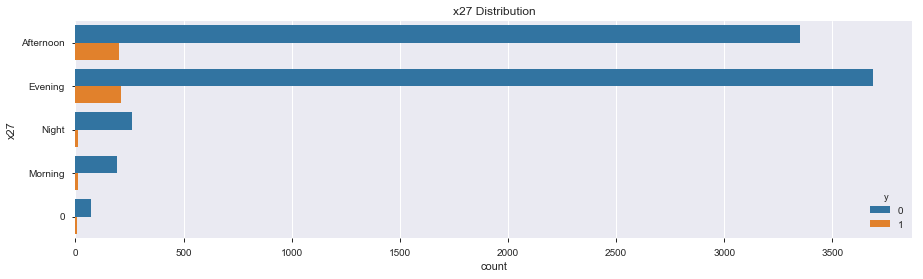

In [40]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="x27", hue='y', data=data).set_title('x27 Distribution');

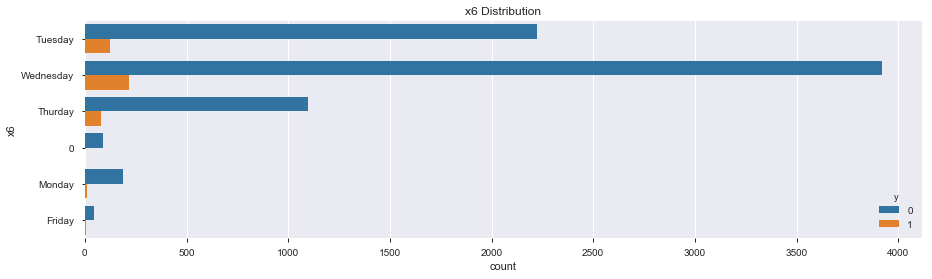

In [41]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="x6", hue='y', data=data).set_title('x6 Distribution');

#### We will use Label Encoding for converting their values to numerical values.

In [42]:
## Label encoding, converting each value in a column to a number

cleanup_nums = {"x6":  {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thurday": 4, "Friday": 5 },
                "x27": {"Morning": 1, "Afternoon": 2, "Evening": 3, "Night": 4},
                "x20": {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, 
                        "Jul":7, "Aug": 8, "Sept": 9, "Oct": 10, "Nov": 11, "Dec": 12 }}

data.replace(cleanup_nums, inplace=True)
data.head(5)

x0         x1        x2         x3        x4     x5  x6         x7  \
0 -0.247824   6.425853 -6.485658  -8.241462  0.000000  0.03%   2  -9.808905   
1  2.623274  -2.808263  5.321746  -2.437653  0.614041  0.02%   3  10.710053   
2 -5.460551   5.997701 -4.614194  -6.035128 -1.986438  -0.0%   2  -3.364649   
3  1.566307  -0.080517  0.064754   6.063193 -2.253075   0.0%   4  -6.111982   
4  0.750715  15.656095 -6.778600  11.251037 -0.308200   0.0%   3   2.498892   

         x8        x9 ...       x91        x92        x93       x94       x95  \
0  4.753455  2.537819 ...  0.592543  14.967527   6.691044 -0.275572  2.518542   
1  1.608882 -2.027541 ... -1.712788  -3.638637  -2.256492  2.703101  1.760729   
2 -2.493473  1.429913 ...  2.206956   7.292558  10.095556  1.601155  1.710645   
3 -1.796377 -3.169510 ... -3.841669   5.189840  10.291069 -3.642396  0.674300   
4 -0.323229 -2.624680 ...  8.933781  -7.295794 -11.246059 -4.876594  3.395415   

         x96        x97       x98       x99  y  
0   4.637431 -14.296510  1.898115 -1.225228  0  
1   2.660614   1.182922 -3.203078  0.711018  0  
2 -12.519434  -5.261707  2.032666 -6.445528  0  
3  -1.104317  -3.922342 -0.613947  7.275179  0  
4  -2.646844  -5.273267 -5.259536 -3.240523  0  

[5 rows x 101 columns]

#### Converting columns x5 and x57 to int by removing % and $

In [43]:
## Converting columns x5 and x57 to int by removing % and $

df_5 = data.x5
df_5 = pd.to_numeric(df_5.str.replace('%', ''))
data['encoded_x5'] = df_5

## Converting x49 to numerical column 
data['x49'] = data['x49'] *1

##
df_57 = data.x57
df_57 = pd.to_numeric(df_57.str.replace('$', ''))
data['encoded_x57'] = df_57

data = data.drop(['x5'], axis=1)
data = data.drop(['x57'], axis=1)
data = data.fillna(0)

## Detailed sumamry of data. We can find out:

#### what features are highly correlated: Some features are highly correlated. (x61 and x35, x76 and x32, x95 and x81)

#### If we have outliers : Since the feature distributions are not skewed and they are roughly normally distributed, outliers are not major issues. 

In [45]:
import warnings
warnings.filterwarnings('ignore')

import pandas_profiling
pandas_profiling.ProfileReport(data)

#### Now, lets remove the last coulmn (Label feature) and create input features.

In [46]:
x = data.drop(label_list,axis = 1 )
x_columns = x.columns

## Lets visualize some highly correlated features 

#### more than %98 correlation between x61 and x35 . We can remove one of them for analysis.

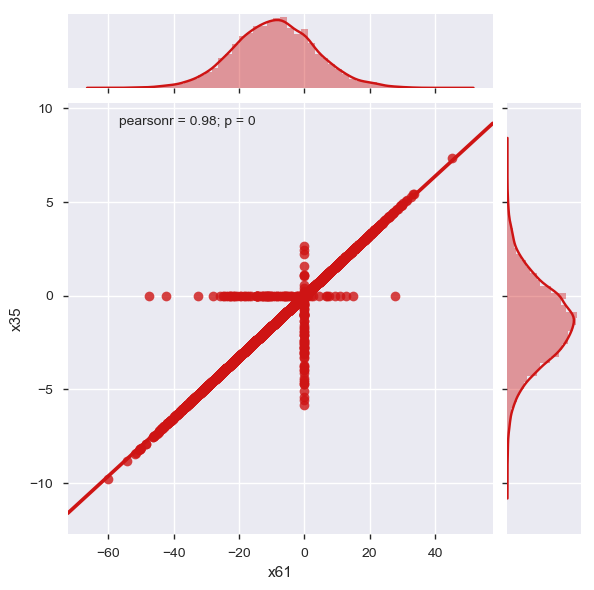

In [47]:
sns.jointplot(x.loc[:,'x61'], x.loc[:,'x35'], kind="regg", color="#ce1414")
plt.show()

### Calculating the correlation between label (y) and inputs. 

#### As we see, the features are ranked based on their correlation with label feature. Top features are more suitable for building a classification model.

In [48]:
df_corr = data.corr().iloc[98,:]
ddd = {'Correlation with label (y)' : pd.Series(df_corr)}
df_cor = pd.DataFrame(ddd)
df_cor['sort'] = df_cor['Correlation with label (y)'].abs()
df_cor.sort_values(by=['sort'] , ascending=False).drop('sort', axis=1)

Correlation with label (y)
y                              1.000000
x54                           -0.194727
x61                            0.145668
x35                            0.145053
x41                            0.134611
x12                           -0.124924
x1                             0.114474
x95                           -0.104245
x81                           -0.102528
x32                            0.094328
x76                            0.092823
x50                            0.037330
x39                            0.037181
x11                           -0.030578
x73                           -0.028932
x85                           -0.028304
x13                            0.027008
x66                           -0.026466
x62                           -0.024052
x26                           -0.023430
x9                            -0.021018
x6                             0.020594
x30                            0.020410
x71                            0.020323
x70                            0.017639
x58                           -0.017634
x60                            0.017385
x91                           -0.017190
x49                           -0.016937
x99                           -0.016698
...                                 ...
x89                           -0.004419
x23                           -0.004118
x83                           -0.004016
x69                           -0.003614
x48                            0.003563
x7                            -0.003515
x22                           -0.002798
x42                            0.002653
x24                           -0.002429
x43                            0.002323
x75                            0.002154
x87                            0.002123
x67                           -0.002033
x51                            0.001861
x98                           -0.001794
x34                           -0.001534
x2                            -0.001520
x68                            0.001482
x25                           -0.001436
encoded_x57                   -0.001426
x20                            0.001383
x56                            0.001311
x40                            0.000984
x33                           -0.000911
x97                            0.000844
x15                            0.000806
x96                           -0.000772
x92                            0.000772
x86                           -0.000677
x46                           -0.000127

[101 rows x 1 columns]

### Plot the correlation between label (y) and x54 

#### As we see, correlation is not considerable.

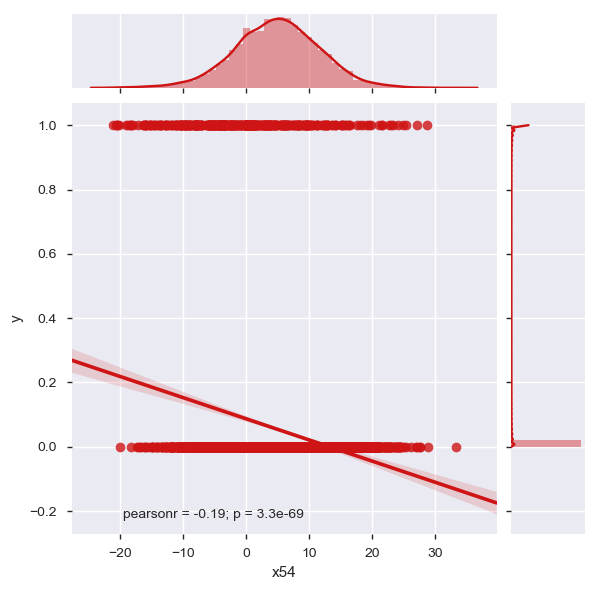

In [50]:
sns.jointplot(data.loc[:,'x54'], data.loc[:,'y'], kind="regg", color="#ce1414")
plt.show()

### Calcualting the effect size 

#### Effect size is a simple way of quantifying the difference between two groups that has many advantages over the use of tests of statistical significance alone. Effect size emphasises the size of the difference rather than confounding this with sample size.

Cohen suggested that d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. 

#### Features with high effect size are suitable for classification model.

#### We will visualize top 3 features ranked by the effect size.

In [54]:
data_R = x[label == 1]
data_NR = x[label == 0]
effect_size = np.zeros(len(x.columns))
for i in range(len(x.columns)):
    mean_diff = data_R.loc[:,x.columns[i]].mean() - data_NR.loc[:,x.columns[i]].mean()
    var_NR = data_NR.loc[:,x.columns[i]].var()
    var_R = data_R.loc[:,x.columns[i]].var()
    var_pooled = (len(data_R)*var_R +len(data_NR)*var_NR ) / float(len(data_R)+ len(data_NR))
    effect_size[i] = mean_diff/np.sqrt(var_pooled)
    #print("Effect size of ",x.columns[i],"is: " effect_size)
    #print("Effect size of %s is: %f" % (x.columns[i], effect_size[i]))
d = {'Data Columns' : pd.Series(x.columns), 'Effect Size' : pd.Series(effect_size)}
df = pd.DataFrame(d)
df['sort'] = df['Effect Size'].abs()
df.sort_values(by=['sort'] , ascending=False).drop('sort', axis=1)

Data Columns  Effect Size
53          x54    -0.871586
59          x61     0.646428
34          x35     0.643641
40          x41     0.596436
11          x12    -0.552816
1            x1     0.505938
93          x95    -0.460170
79          x81    -0.452512
31          x32     0.416007
74          x76     0.409309
49          x50     0.164011
38          x39     0.163354
10          x11    -0.134318
71          x73    -0.127077
83          x85    -0.124317
12          x13     0.118623
64          x66    -0.116239
60          x62    -0.105628
25          x26    -0.102898
8            x9    -0.092303
5            x6     0.090436
29          x30     0.089626
69          x71     0.089245
68          x70     0.077457
56          x58    -0.077434
58          x60     0.076340
89          x91    -0.075481
48          x49    -0.074374
97          x99    -0.073321
37          x38    -0.071438
..          ...          ...
87          x89    -0.019400
22          x23    -0.018082
81          x83    -0.017634
67          x69    -0.015868
47          x48     0.015644
6            x7    -0.015433
21          x22    -0.012286
41          x42     0.011646
23          x24    -0.010664
42          x43     0.010198
73          x75     0.009455
85          x87     0.009323
65          x67    -0.008925
50          x51     0.008171
96          x98    -0.007877
33          x34    -0.006735
2            x2    -0.006675
66          x68     0.006506
24          x25    -0.006306
99  encoded_x57    -0.006260
19          x20     0.006072
55          x56     0.005758
39          x40     0.004321
32          x33    -0.003998
95          x97     0.003705
14          x15     0.003541
94          x96    -0.003389
90          x92     0.003389
84          x86    -0.002973
45          x46    -0.000557

[100 rows x 2 columns]

Text(0.5,1,'x54 Distribution - Non-Fraud V.S. Fraud')

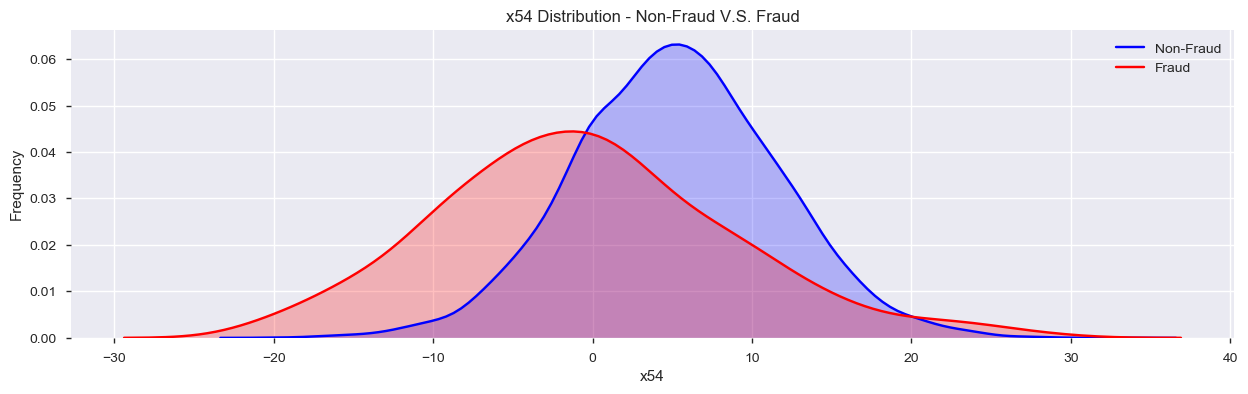

In [68]:
i = 53
# Kernel Density Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(data.loc[(data['y'] == 0),data.columns[i]] , color='b',shade=True,label='Non-Fraud')
ax=sns.kdeplot(data.loc[(data['y'] == 1),data.columns[i]] , color='r',shade=True, label='Fraud')
ax.set(xlabel=data.columns[i], ylabel='Frequency')
plt.title( data.columns[i] + ' Distribution - Non-Fraud V.S. Fraud')

Text(0.5,1,'x61 Distribution - Non-Fraud V.S. Fraud')

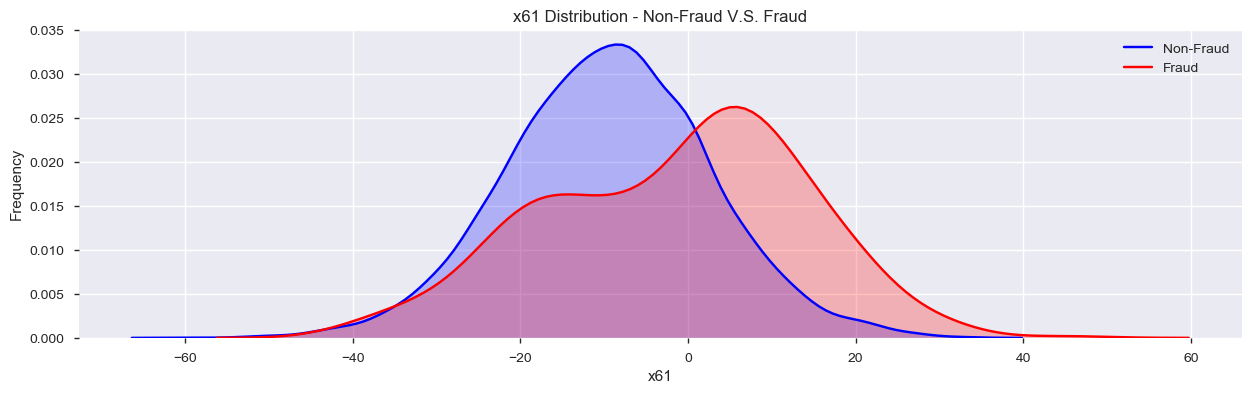

In [56]:
i = 59
# Kernel Density Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(data.loc[(data['y'] == 0),data.columns[i]] , color='b',shade=True,label='Non-Fraud')
ax=sns.kdeplot(data.loc[(data['y'] == 1),data.columns[i]] , color='r',shade=True, label='Fraud')
ax.set(xlabel=data.columns[i], ylabel='Frequency')
plt.title( data.columns[i] + ' Distribution - Non-Fraud V.S. Fraud')

Text(0.5,1,'x35 Distribution - Non-Fraud V.S. Fraud')

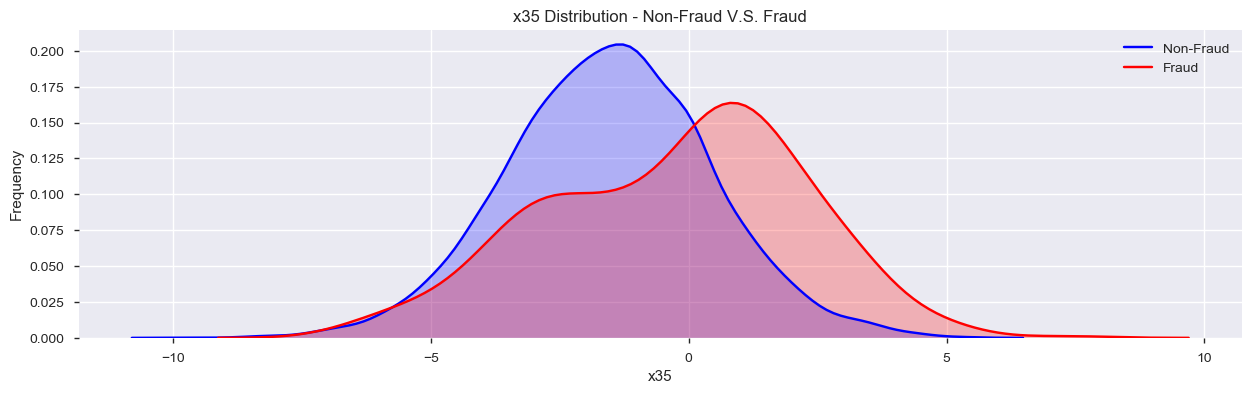

In [63]:
i = 34
# Kernel Density Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(data.loc[(data['y'] == 0),data.columns[i]] , color='b',shade=True,label='Non-Fraud')
ax=sns.kdeplot(data.loc[(data['y'] == 1),data.columns[i]] , color='r',shade=True, label='Fraud')
ax.set(xlabel=data.columns[i], ylabel='Frequency')
plt.title( data.columns[i] + ' Distribution - Non-Fraud V.S. Fraud')

#### Interestingly, x34 and x61 distributions are so similar. I plot their correlations.
#### The result is surprisingly low correlation between these 2 features. 

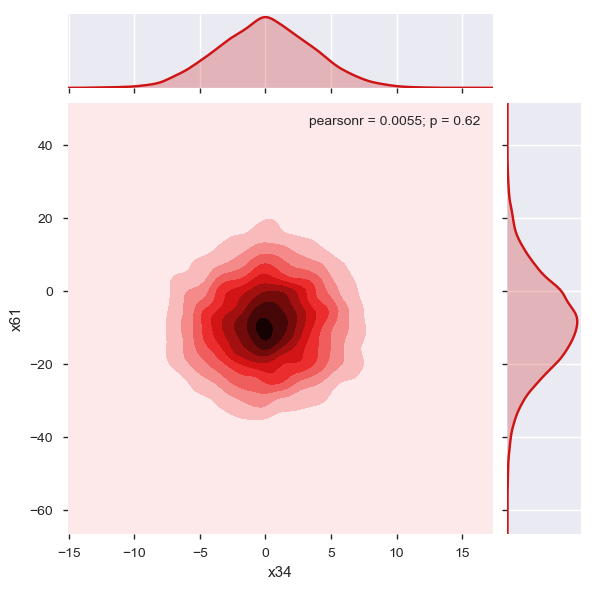

In [65]:
sns.jointplot(data.loc[:,'x34'], data.loc[:,'x61'], kind="kde", color="#ce1414")
plt.show()

#### I plot the lowest ranked feature (Minimum effect size & highly over-lapped distribution)

Text(0.5,1,'x46 Distribution - Non-Fraud V.S. Fraud')

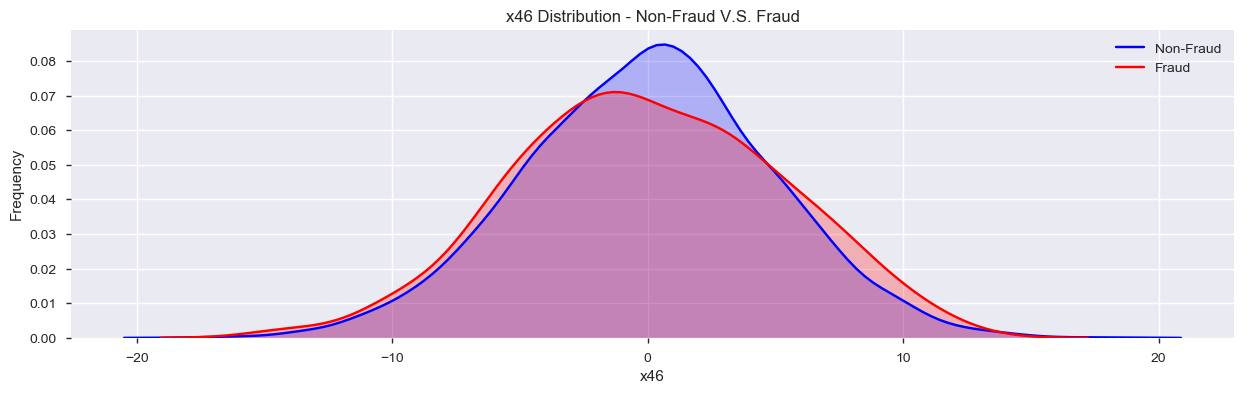

In [69]:
i = 45
# Kernel Density Plot
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(data.loc[(data['y'] == 0),data.columns[i]] , color='b',shade=True,label='Non-Fraud')
ax=sns.kdeplot(data.loc[(data['y'] == 1),data.columns[i]] , color='r',shade=True, label='Fraud')
ax.set(xlabel=data.columns[i], ylabel='Frequency')
plt.title( data.columns[i] + ' Distribution - Non-Fraud V.S. Fraud')

In [70]:
# convert a pandas dataframe to a numpy ndarray

x = x.values
x = x.astype(np.float64)

### looking for duplicate records: No

In [ ]:
# Duplicate rows? No

normal_duplicates = sum( data.loc[ data.y==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.y==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates: ', normal_duplicates )
print( 'Fraud duplicates: ', fraud_duplicates )
print( 'Total duplicates: ', total_duplicates )
print( 'Fraction duplicated: ', total_duplicates / len(data) )

#### Plot the label, %94 of the dataset is legal transactions and only %6 is fraud transactions.

Number of Non-Fraud:  7561
Number of Fraud :  439


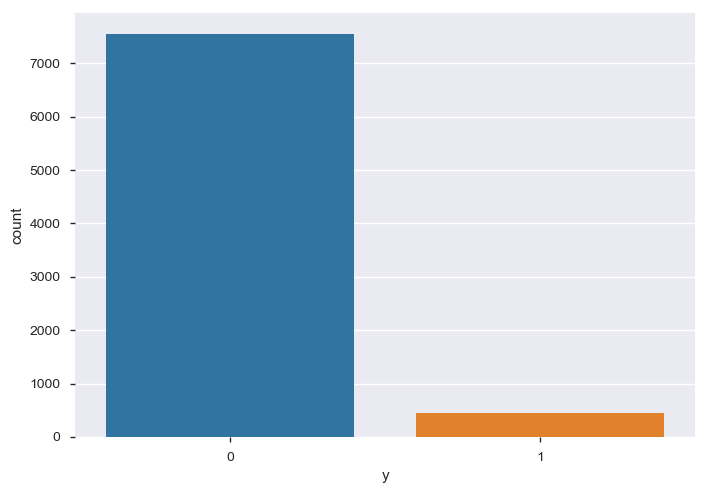

In [74]:
ax = sns.countplot(label , label = "Count")     
NF, F = label.value_counts()
print('Number of Non-Fraud: ',NF)
print('Number of Fraud : ',F)

#### Splitting the dataset into %60 training set and %40 testing set and applying Random Forest classification

In [77]:
kshuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=seed)
for train_index, test_index in kshuffle.split(x, label):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

### There are 176 fraud records and 3024 legal records in the test set. 

|         | DATASET           | TRAIN  | TEST  | 
| ------------- |:-------------:| -----:|-----:|
| No Fraud      | 7561 | 4537 |3024 | 
| Fraud      | 439      |    263| 176 |
| Total | 8000      |   4800 | 3200 |

In [78]:
print("Lenght Test class zero:", sum(y_test == 0))
print("Lenght Test class one:", sum(y_test == 1))
print("Lenght Train class zero:", sum( y_train == 0))
print("Lenght Train class one:", sum( y_train == 1))

Lenght Test class zero: 3024
Lenght Test class one: 176
Lenght Train class zero: 4537
Lenght Train class one: 263


In [101]:
## Test the best result with optimized for Recall

from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

clf = RandomForestClassifier(bootstrap= False, criterion= 'entropy', max_depth= 36.0, max_features= 40, 
                             min_samples_leaf= 10, min_samples_split= 11, n_estimators= 240)

clf.fit(x_train, y_train)

y_score = clf.predict_proba(x_test)[:,1]

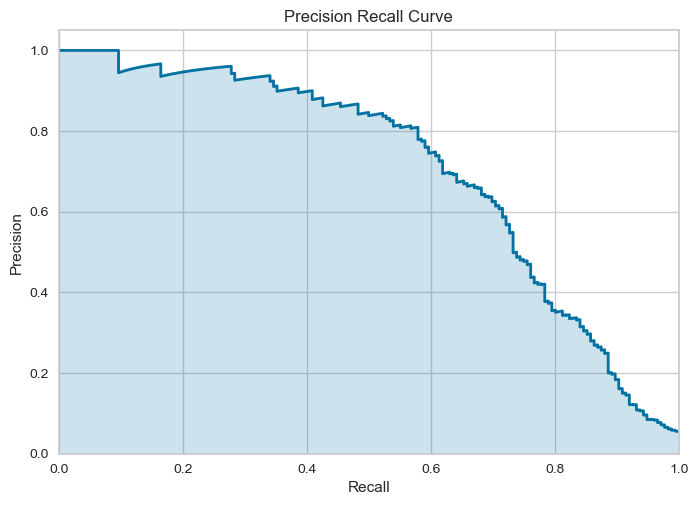

Average precision-recall score: 0.706


In [102]:
# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()


average_precision = average_precision_score(y_true.values, y_score)

print('Average precision-recall score: {0:0.3f}'.format(average_precision))

### K-S Chart 

K-S or Kolmogorov-Smirnov is a measure of the degree of separation between the positive and negative distributions. 
The K-S is 1 if the scores partition the population into two separate groups in which one group contains all the positives and the other all the negatives. On the other hand, If the model cannot differentiate between positives and negatives, then it is as if the model selects cases randomly from the population. The K-S would be 0. 
In most classification models the K-S will fall between 0 and 1, and that the higher the value the better the model is at separating the positive from negative cases.

#### The result shows that we could achieve K-S = 0.753 

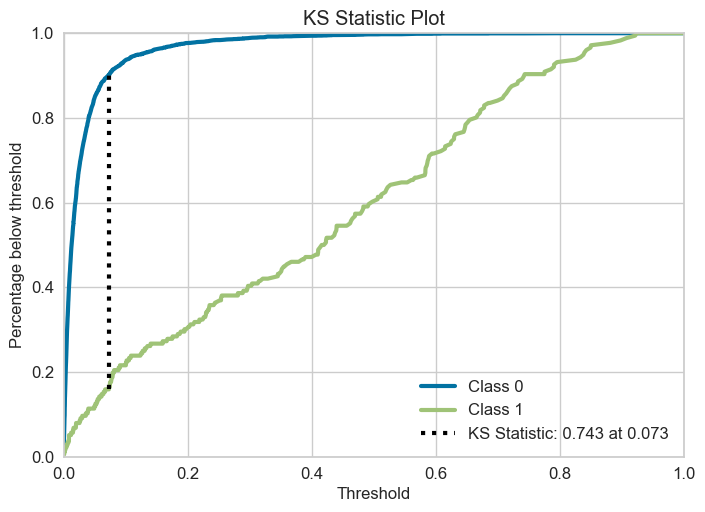

In [103]:
skplt.metrics.plot_ks_statistic(y_true=y_true, y_probas = clf.predict_proba(x_test))
plt.show()

### Confusion matrix

#### Based on the threshold (decision boundary) of K-S Chart (which is 0.073), we adjust our threshold (default is 0.5 in the scale of (0,1))

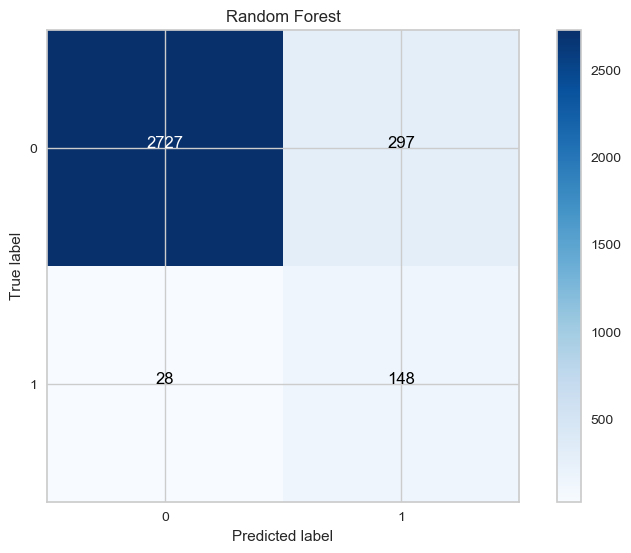

Precision =     0.333
Recall    =     0.841
F1_score  =     0.477
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.90      0.84      0.94      0.57      0.35      3024
          1       0.33      0.84      0.90      0.48      0.57      0.31       176

avg / total       0.95      0.90      0.84      0.92      0.57      0.35      3200



In [104]:
y_pred = np.zeros(y_score.shape[0])
for i in range(0,y_score.shape[0]):
    if y_score[i] >=0.073: ## lower the lower FP
        y_pred[i] = 1

y_true  = y_test

# Confusion maxtrix & metrics
cm = confusion_matrix(y_true, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'Random Forest')
plt.show()

show_metrics()
fpr, tpr, t = roc_curve(y_test, y_score)



# Report for precision/recall/specificity, geometric mean, and index balanced accuracy of the geometric mean.
print(classification_report_imbalanced(y_true, y_pred))

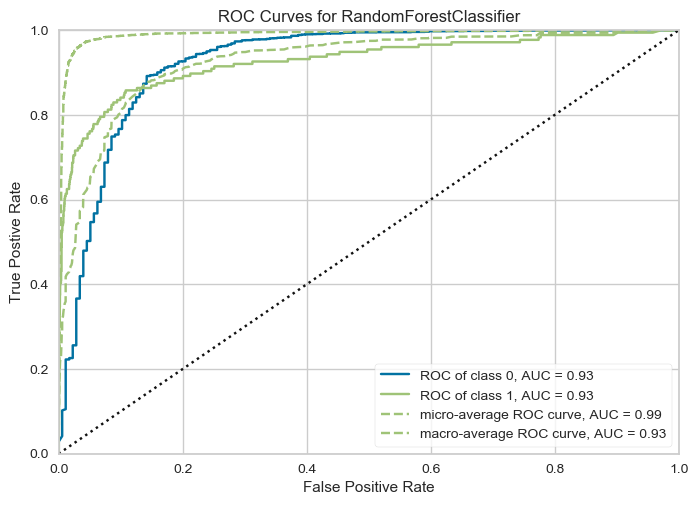

In [81]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### Top 10 important Features
# I have lot to say about how to find most important features. I will provide the detail later.

Text(0.5,0,'Relative Importance')

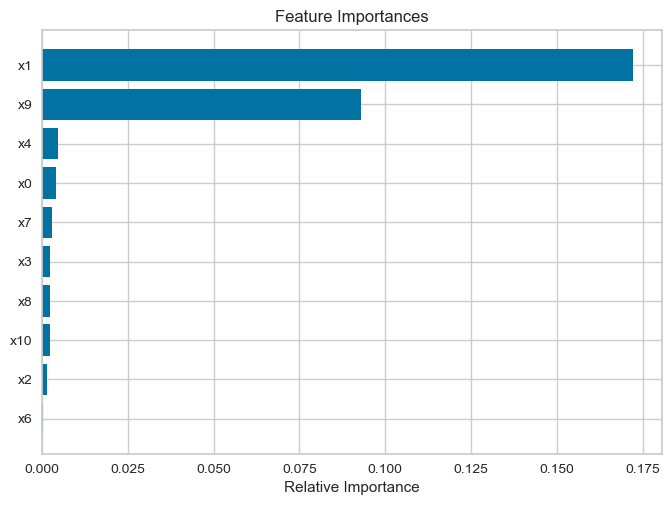

In [82]:
importances = clf.feature_importances_[:10]
indices = np.argsort(importances)
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), x_columns[indices])
plt.xlabel('Relative Importance')

### Lift Curve 

The lift chart shows how much more likely we are to receive positive responses than if we pick a random sample of customers. 

#### The result shows that by picking 20% of customers based on the predictive model (Random Forest) we will reach 4 times as many respondents, as if we use no model.

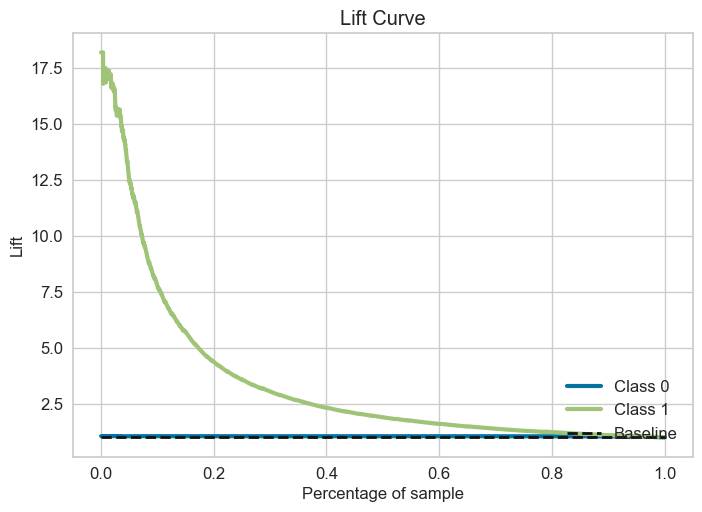

In [83]:
import scikitplot as skplt

skplt.metrics.plot_lift_curve(y_true=y_true, y_probas=clf.predict_proba(x_test))
plt.show()

### Learning curve

Generates a plot of the train and test learning curves for a classifier.

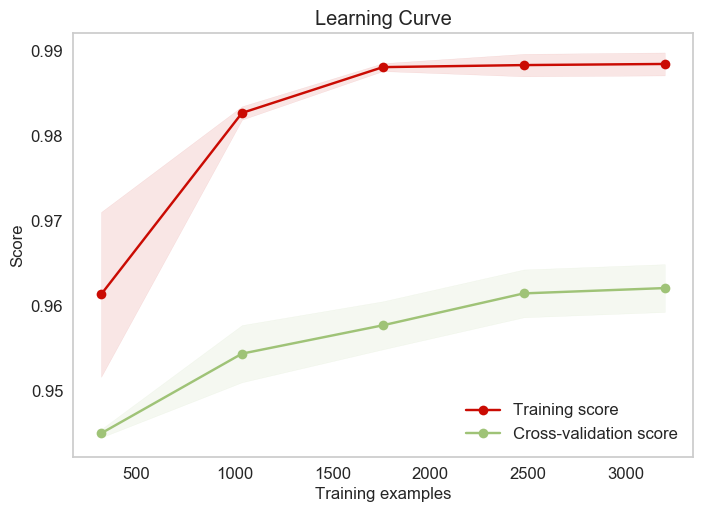

In [85]:
skplt.estimators.plot_learning_curve(clf, x_train, y_train)
plt.show()

### Gain Curve

Generates the Cumulative Gains Plot from labels and scores/probabilities

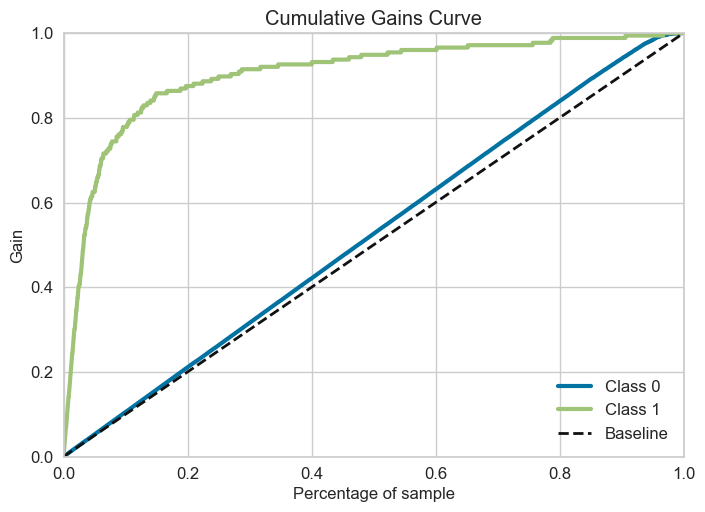

In [86]:
skplt.metrics.plot_cumulative_gain(y_true, clf.predict_proba(x_test))
plt.show()

#### Now, we apply PCA method to find two major component to visualize the dataset 

##### As we see, fraud and legal transactions are not separated.

The image will open in a separate tab.

In [106]:
import plotly
plotly.tools.set_credentials_file(username='mikepar', api_key='bpXlFyjGrIh2ISjDXqmG')
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

## normalize the dataset
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(x)

## Apply PCA with 2 components

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

traces = []

for name in (0, 1):

    trace = Scatter(
        x=Y_sklearn[label==name,0],
        y=Y_sklearn[label==name,1],
        mode='markers',
        name=name,
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


dataa = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=dataa, layout=layout)
py.plot(fig)


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mikepar/0 or inside your plot.ly account where it is named 'plot from API'


'https://plot.ly/~mikepar/0'